In [1]:
import IP
from IP import imread, imresize, randn, dtfuv, fftfilt, np, imshow, rgb2gray, plt, fft2, ifft2, fftshift
import scipy
from scipy.signal import wiener
import skimage

In [2]:
# the following code is based on using the baboon image
# if wanting to use own digital photograph with no ground truth, go to the last cell and switch the commented code

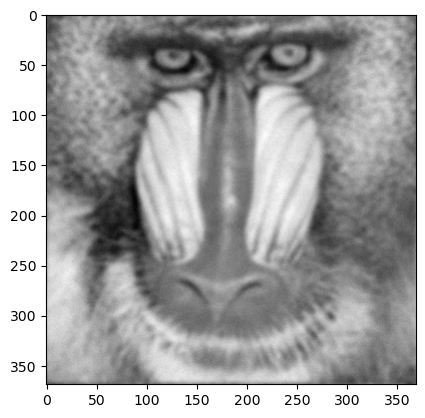

In [3]:
# read broken image with unknown blur and noise
png_I_blur = imread("blurred_noisy_baboon.png")
rgb_I_blur = png_I_blur[:,:,:3]
I_blur = rgb2gray(rgb_I_blur)
plt.figure()
imshow(I_blur, aspect="equal", cmap="gray")

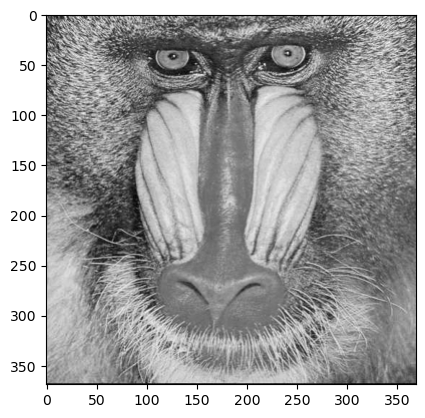

In [4]:
# read ground truth image
I_truth = rgb2gray(imread("baboon.jpg"))
# I_truth = rgb2gray(imread("../tiger.jpg"))
I_truth = imresize(I_truth, I_blur.shape[0], I_blur.shape[1])
plt.figure()
imshow(I_truth, aspect="equal", cmap="gray")

In [5]:
# returns "inverse filter" with ground truth, originall used to test EM loop
# prior to implementation of wiener estimate
def gound_truth_psf_estimate(Ig, Ii, n, noise_signal_ratio=0.001):
    Igf = fft2(Ig, Ii.shape)
    Iif = fft2(Ii, Ii.shape)
    epsilon = 1e-10
    H = Iif / (Igf+epsilon)
    plt.imshow(np.log10(1+np.abs(fftshift(H))), aspect="equal", cmap="gray")
    filename = f'./test6/baboon_{1+n}.png'
    plt.savefig(filename)
    return H / H.sum() # normalize

In [6]:
# returns Gaussian lowpass filter
def GLPF(I, D0):
    U,V=dtfuv(I.shape[0],I.shape[1])
    D = IP.np.sqrt(U**2+V**2)
    filt=IP.np.exp(-D**2/(2*(D0**2)))
    return filt

In [7]:
# returns wiener filter (according to paper, though we do not use this in our implementation)
def wiener_filt(Ii, H, noise_signal_ratio):
    wiener_f = np.conj(H)/(np.abs(H)**2+(noise_signal_ratio))
    Iif = fft2(Ii, Ii.shape)
    Iif = Iif
    wiener_f = wiener_f*Iif
    return wiener_f

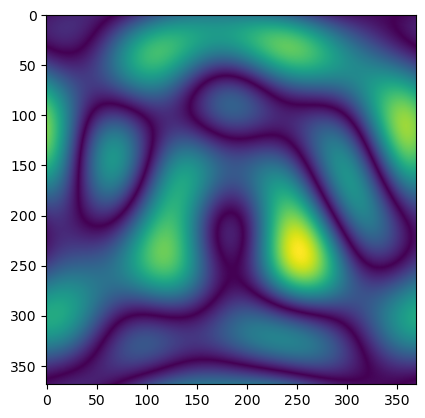

In [8]:
# visualization of what paper wiener filter hypothetically looks like
ww = fft2(wiener_filt(I_blur, GLPF(I_blur, 1), 0.001))
imshow(np.abs(ww))

In [9]:
# attempt to calculate covariance
def covariance(I):
    # Create a shifted version of the image
    shifted_image = np.roll(I, shift=1, axis=0)

    # Flatten the arrays to 1D
    image_flat = I.flatten()
    shifted_image_flat = shifted_image.flatten()

    # Calculate covariance
    covariance = np.cov(image_flat, shifted_image_flat)[0, 1]
    return covariance

In [10]:
# Laplacian filter used for penalty term implementation, according to paper
def Laplacian(I):
    LPF = IP.np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
    return np.abs(IP.filter2D(I,LPF,"same"))

In [11]:
# Method 2 psf implementation without penalty term
def psf_estimate(Iog, Ii, n, noise_signal_ratio=0.001):
    epsilon = 1e-10
    Iif = fft2(Ii, Ii.shape)
    # scipy wiener filter
    wienerfilter = fft2(wiener(Ii), Ii.shape)
    
    # paper manual implementation of wiener filter
    # wienerfilter = wiener_filt(I_blur, GLPF(I_blur, 1), 0.001)
    
    wienerfilter = wienerfilter/wienerfilter.sum()
    variance = covariance(np.log10(1+np.abs(fftshift(Iif))))
    n_variance = (1/Ii.shape[0]*Ii.shape[1])*np.sum(variance+(1/(Ii.shape[0]*Ii.shape[1]))*(np.abs(wienerfilter)**2))
    H = (Iif*np.conj(wienerfilter))/((Ii.shape[0]*Ii.shape[1])*n_variance+epsilon)
    return H / H.sum()

In [12]:
# Method 2 psf implementation with penalty term ATTEMPT
def psf_estimate_penalty(Iog, Ii, n, noise_signal_ratio=0.001):
    epsilon = 1e-10
    Iif = fft2(Ii, Ii.shape)
#     wienerfilter = fft2(wiener(Ii), Ii.shape)
    wienerfilter = wiener_filt(I_blur, GLPF(I_blur, 1), 0.001)
    wienerfilter = wienerfilter/wienerfilter.sum()
#     variance = np.cov(np.log10(1+np.abs(fftshift(Iif))))
    variance = np.cov(Iif)
    LPF = IP.np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
    LPF_filt = fft2(LPF, Ii.shape)
#     LPF_filt = LPF_filt/LPF_filt.sum()
    alpha = 5
    n_variance = variance+(1/Ii.shape[0]*Ii.shape[1])*(np.abs(wienerfilter)**2)
    p_variance = (-1+(1+(4*alpha*LPF_filt)*n_variance)**0.5)/(2*alpha*LPF_filt+epsilon)
    H = (Iif*np.conj(wienerfilter))/((Ii.shape[0]*Ii.shape[1])*p_variance+epsilon)
    plt.imshow(np.log10(1+np.abs(fftshift(H))), aspect="equal", cmap="gray")
    filename = f'./test2/baboon_{1+n}.png'
    plt.savefig(filename)
    return H / H.sum()

In [13]:
# iterative loop for demo purposes (no penalty term aka method 2, and using baboon image)
def demo_EM_loop(Ig, Ii, k):
    estimated_image = Ii
    plt.figure(figsize=(10,5))
    IP.subplot(1,2,1);imshow((estimated_image), aspect="equal", cmap="gray"); plt.title(f'Estimated image iter -1')
    IP.subplot(1,2,2);imshow((np.abs(Ig-estimated_image/estimated_image.max())*Ig.max()), aspect="equal", cmap="gray"); plt.title(f'Difference from ground truth iter -1')

    filename = f'./demo/baboon_0.png'
    plt.savefig(filename)
    for i in range(k):
        psf = psf_estimate(Ii, estimated_image, i, 0.001)
        estimated_image_fft = fft2(estimated_image)
        psf_fft = fft2(psf, estimated_image.shape)
        psf_fft = psf_fft/psf_fft.max()
        
        #deconvolution
        epsilon = 1e-10
        decon_fft = estimated_image_fft / (psf_fft + epsilon)
        
        estimated_image = np.abs(ifft2(decon_fft))
        print("loop",i," ",np.sum(np.abs(Ig-(estimated_image/estimated_image.max())*Ig.max())**2))
        plt.figure(figsize=(10,5))
        IP.subplot(1,2,1);imshow((estimated_image), aspect="equal", cmap="gray"); plt.title(f'Estimated image iter {i}')
        IP.subplot(1,2,2);imshow((np.abs(Ig-estimated_image/estimated_image.max())*Ig.max()), aspect="equal", cmap="gray"); plt.title(f'Difference from ground truth iter {i}')
        
        filename = f'./demo/baboon_{1+i}.png'
        plt.savefig(filename)
        plt.close()
        
    return (estimated_image/estimated_image.max())*Ig.max()

In [14]:
# iterative loop without ground truth (no penalty term aka method 2)
def EM_loop(Ii, k):
    estimated_image = Ii
    plt.figure(figsize=(10,5))
    IP.subplot(1,2,1);imshow(Ii, aspect="equal", cmap="gray"); plt.title(f'Broken image iter -1')
    IP.subplot(1,2,2);imshow(estimated_image, aspect="equal", cmap="gray"); plt.title(f'Estimated image -1')
    filename = f'./test/baboon_0.png'
    plt.savefig(filename)
    plt.close()
    for i in range(k):
        psf = psf_estimate(Ii, estimated_image, i, 0.001)
        estimated_image_fft = fft2(estimated_image)
        psf_fft = fft2(psf, estimated_image.shape)
        psf_fft = psf_fft/psf_fft.sum()
        
        #deconvolution
        epsilon = 1e-10
        decon_fft = estimated_image_fft / (psf_fft + epsilon)
        
        estimated_image = np.abs(ifft2(decon_fft))
        estimated_image = estimated_image/estimated_image.max()*Ii.max()
        plt.figure(figsize=(10,5))
        IP.subplot(1,2,1);imshow((Ii), aspect="equal", cmap="gray"); plt.title(f'Broken image')
        
        # with histogram equalization
        IP.subplot(1,2,2);imshow(skimage.exposure.equalize_hist(estimated_image/estimated_image.max()*Ii.max()), aspect="equal", cmap="gray"); plt.title(f'Estimated image iter {i}')
        # no histogram equalization
        # IP.subplot(1,2,2);imshow((estimated_image/estimated_image.max())*Ii.max(), aspect="equal", cmap="gray"); plt.title(f'Estimated image iter {i}')

        filename = f'./test/baboon_{1+i}.png'
        plt.savefig(filename)
        plt.close()
        
    return (estimated_image/estimated_image.max())*Ii.max()

In [15]:
# iterative loop without ground truth (yes penalty term aka method 1) ATTEMPT
def EM_loop_penalty(Ii, k):
    estimated_image = Ii
    plt.figure(figsize=(10,5))
    IP.subplot(1,2,1);imshow(Ii, aspect="equal", cmap="gray"); plt.title(f'Broken image iter -1')
    IP.subplot(1,2,2);imshow(estimated_image, aspect="equal", cmap="gray"); plt.title(f'Estimated image -1')
    filename = f'./test/baboon_0.png'
    plt.savefig(filename)
    plt.close()
    for i in range(k):
        psf = psf_estimate_penalty(Ii, estimated_image, i, 0.001)
        estimated_image_fft = fft2(estimated_image)
        psf_fft = fft2(psf, estimated_image.shape)
        psf_fft = psf_fft/psf_fft.sum()
        
        #deconvolution
        epsilon = 1e-10
        decon_fft = estimated_image_fft / (psf_fft + epsilon)
        
        
        estimated_image = np.abs(ifft2(decon_fft))
#         estimated_image = estimated_image + 0.1*i/2*Laplacian(estimated_image)
        estimated_image = estimated_image/estimated_image.max()*Ii.max()
        plt.figure(figsize=(10,5))
        IP.subplot(1,2,1);imshow((Ii), aspect="equal", cmap="gray"); plt.title(f'Broken image')
        IP.subplot(1,2,2);imshow(skimage.exposure.equalize_hist(estimated_image/estimated_image.max()*Ii.max()), aspect="equal", cmap="gray"); plt.title(f'Estimated image iter {i}')
#         IP.subplot(1,2,2);imshow((estimated_image/estimated_image.max())*Ii.max(), aspect="equal", cmap="gray"); plt.title(f'Estimated image iter {i}')

        filename = f'./test/baboon_{1+i}.png'
        plt.savefig(filename)
        plt.close()
        
    return (estimated_image/estimated_image.max())*Ii.max()

loop 0   1012.1325888643477
loop 1   986.7602397452406
loop 2   966.2948105283962
loop 3   952.3270369813977
loop 4   946.9642127211421
loop 5   952.9086466908592
loop 6   974.5000652733718
loop 7   1022.7247050191764
loop 8   1106.4214588389418
loop 9   1236.7400545343048
loop 10   1427.4325361258125
loop 11   1698.2892596656916
loop 12   2075.6831940723114
final error 2075.6831940723114


Text(0.5, 1.0, 'Difference')

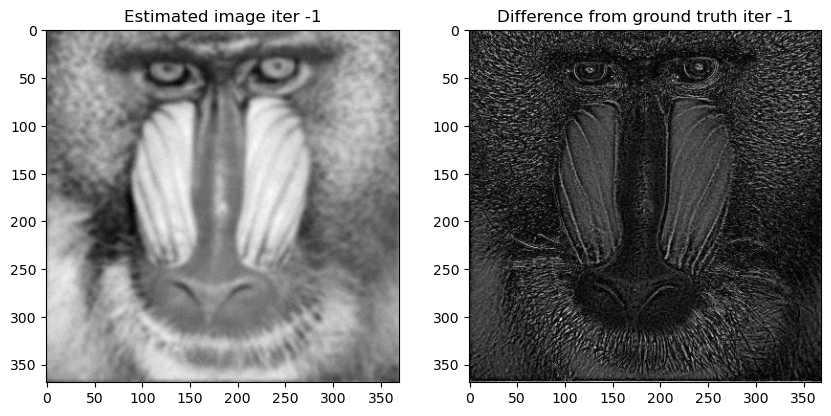

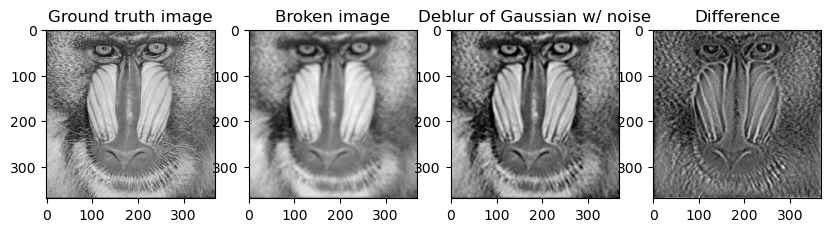

In [16]:
# baboon image aka with ground turth (can see deviation from ground truth)
estimate = demo_EM_loop(I_truth, I_blur, 13)
print("final error", np.sum(np.abs(I_truth-estimate)**2))

plt.figure(figsize=(10,5))
IP.subplot(1,4,1);imshow(I_truth, aspect="equal", cmap="gray"); plt.title('Ground truth image')
IP.subplot(1,4,2);imshow(I_blur, aspect="equal", cmap="gray"); plt.title('Broken image')
IP.subplot(1,4,3);imshow(estimate, aspect="equal", cmap="gray"); plt.title('Deblur of Gaussian w/ noise')
IP.subplot(1,4,4);imshow(np.abs(I_blur-estimate), aspect="equal", cmap="gray"); plt.title('Difference')

/Users/AngelinaYang/anaconda3/lib/python3.11/site-packages/scipy/signal/_signaltools.py:1657: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/Users/AngelinaYang/anaconda3/lib/python3.11/site-packages/scipy/signal/_signaltools.py:1657: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


Text(0.5, 1.0, 'Difference')

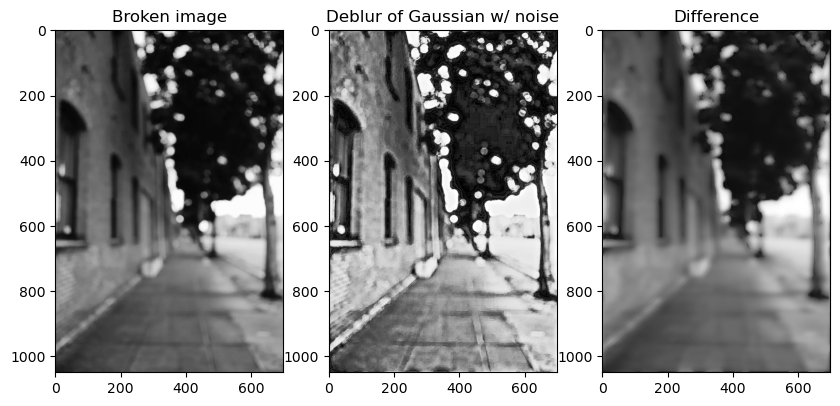

In [17]:
# importing a digital photograph with no ground truth
png_I_blur = imread("street.png")
rgb_I_blur = png_I_blur[:,:,:3]
I_blur = rgb2gray(rgb_I_blur)
# some operations needed square images
# I_blur = imresize(I_blur,300,300)
estimate = EM_loop(I_blur, 6)

plt.figure(figsize=(10,5))
IP.subplot(1,3,1);imshow(I_blur, aspect="equal", cmap="gray"); plt.title('Broken image')
# histogram equalization for better visuals
IP.subplot(1,3,2);imshow(skimage.exposure.equalize_hist(estimate), aspect="equal", cmap="gray"); plt.title('Deblur of Gaussian w/ noise')
# no histogram equalization
# IP.subplot(1,3,2);imshow(estimate, aspect="equal", cmap="gray"); plt.title('Deblur of Gaussian w/ noise')
IP.subplot(1,3,3);imshow(np.abs(I_blur-estimate), aspect="equal", cmap="gray"); plt.title('Difference')